Imports

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, Embedding
from scipy.stats import pearsonr
import keras
from keras_self_attention import SeqSelfAttention
import numpy as np
import pandas as pd
import time

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.fillna(0, inplace=True)
    return agg

### Initial Preprocessing

## Baseline LSTM + room to change network architecture

In [8]:
# load dataset
dataset = pd.read_csv('data/combined_cleaned.csv', header=0, index_col=-1)
values = dataset.values
print(dataset.columns)
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
print(values.shape)
# normalize features (after I reframe into a supervised learning problem)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1, True)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[9:16], axis=1, inplace=True)
#print(reframed.head())

# split into train and test sets
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 60000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(SeqSelfAttention(attention_width=50,
                       attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention'))
model.add(Dense(50,activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary(line_length=100)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'RH', 'WD', 'VWS'], dtype='object')
(84624, 8)
(84624, 16)
(60000, 1, 8) (60000,) (24624, 1, 8) (24624,)
Model: "sequential"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
bidirectional (Bidirectional)                (None, 1, 256)                          140288         
____________________________________________________________________________________________________
Attention (SeqSelfAttention)                 (None, None, 256)                       65537          
____________________________________________________________________________________________________
dense (Dense)                                (None, None, 50)                        12850          
____________________________________________________________________________________________________
dense_1 (Den

In [9]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)    var4(t-1)  var5(t-1)  var6(t-1)  \
0   0.000000   0.000000   0.000000     0.000000       0.00   0.000000   
1  83.699997  32.035999  32.980000  1032.589966       0.57  95.279999   
2  89.849998  26.636000  27.580000  1031.500000       0.57  95.279999   
3  88.470001  26.618000  27.559999  1030.859985       0.57  95.290001   
4  78.019997  26.615999  27.559999  1030.150024       0.57  95.279999   

    var7(t-1)  var8(t-1)    var1(t)  
0    0.000000       0.00  83.699997  
1  144.360001       0.57  89.849998  
2  143.089996       0.57  88.470001  
3  145.100006       0.57  78.019997  
4  141.000000       0.57  66.910004  


### Train and Test Neural Network

Epoch 1/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 2/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 3/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 4/100
834/834 [==============================] - 12s 14ms/step - loss: 0.0105 - val_loss: 0.0124
Epoch 5/100
834/834 [==============================] - 9s 11ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 6/100
834/834 [==============================] - 9s 10ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 7/100
834/834 [==============================] - 11s 13ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 8/100
834/834 [==============================] - 9s 10ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 9/100
834/834 [==============================] - 9s 11ms/step - loss: 0.0098 - val_loss: 0.0118
Epoch 10/100
834/834 [==============================] - 10s 12ms/step - loss:

Epoch 80/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 81/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 82/100
834/834 [==============================] - 11s 13ms/step - loss: 0.0097 - val_loss: 0.0125
Epoch 83/100
834/834 [==============================] - 11s 13ms/step - loss: 0.0096 - val_loss: 0.0126
Epoch 84/100
834/834 [==============================] - 9s 11ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 85/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 86/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 87/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0096 - val_loss: 0.0124
Epoch 88/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0096 - val_loss: 0.0124
Epoch 89/100
834/834 [==============================] - 10s 12ms/st

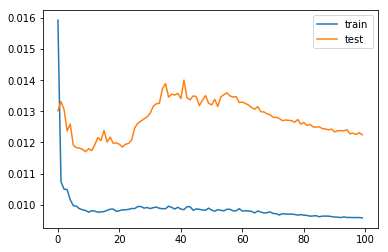

This took 1060.6373989582062 seconds.
Test RMSE: 33.782


In [10]:
start = time.time()

# fit network
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE of 25.654 on best run

### Plot Predicted vs. Actual and Calculate Errors

In [11]:
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [22]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 100 epochs of training')
    ax.plot(true_data, label='True Data', color='green')

    ax.plot(predicted_data, label='Prediction', color='red')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(\mu g / m^3)$')
    plt.legend()
    plt.savefig("lstm_att_regularizer.pdf")
    plt.show()

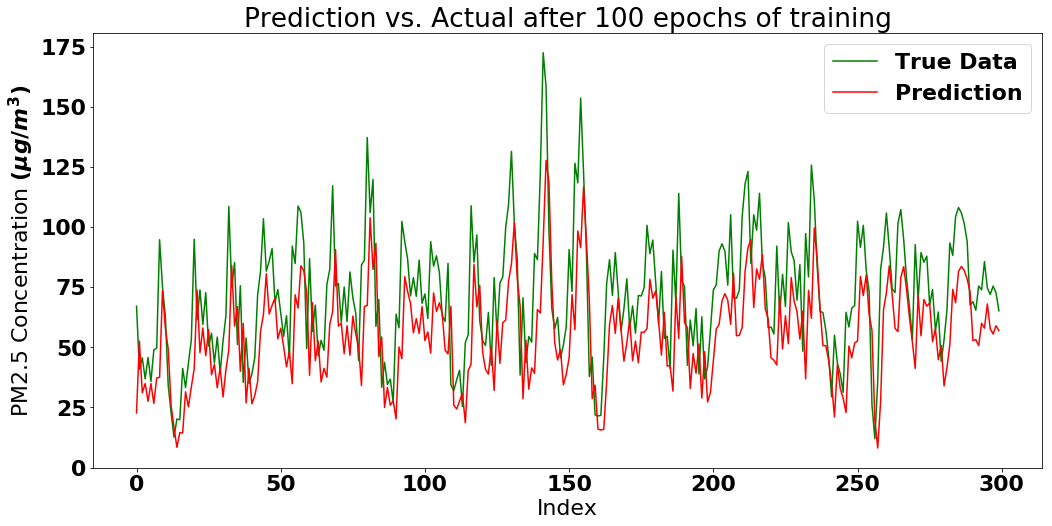

In [23]:
plot_predicted(inv_yhat[424:724,], inv_y[424:724,])

In [14]:
print('Root Mean Squared Error: {:.4f}'.format(rmse))

#Calculate R^2 (regression score function)
#print('Variance score: %.2f' % r2_score(y, data_pred))
print('Variance score: {:2f}'.format(r2_score(inv_y, inv_yhat)))

Root Mean Squared Error: 33.7823
Variance score: 0.476986


In [15]:
corr, _ = pearsonr(inv_y, inv_yhat)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.713
